In [1]:
# %load C60_jupyter_imports.py
%load_ext autoreload
%autoreload 2

import xarray as xr
import numpy as np
from dask.distributed import Client
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy import stats
import xesmf as xe
from scipy.stats import linregress
import os
import requests
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Lets import our functions. There are no tests here. Stored separately so as to not make a mess.
# Make sure in right dir first

os.chdir('/g/data/xv83/np1383/src_CAFE60_eqpac_analysis_code/')

from C60_helper_functions import find_enso_events

In [2]:
# Set up the remote dask cluster. Can either use this version or a similar version above if building a LocalCluster.
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster
cluster = SLURMCluster(cores=2,memory="16GB")
client = Client(cluster)
cluster.scale(cores=16)
#cluster.adapt(minimum=2, maximum=16)
client

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.0.128.132:37267,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [3]:
d=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip',consolidated=True)
for i in d.variables:
    if len(i)<8:
        t='\t\t'
    else:#if len(i)<13:
        t='\t'
    try:
        print(i+t+d[i].units)
    except:
        print(i+t+'no units')

adic		mmol/m^3
alk		mmol/m^3
caco3		mmol/m^3
caco3_sediment	mmolN/m^2
det		mmol/m^3
det_sediment	mmolN/m^2
dic		mmol/m^3
ensemble	no units
export_inorg	mmolC/m^2/s
export_prod	mmolN/m^2/s
fe		mmol/m^3
no3		mmol/m^3
o2		mmol/m^3
paco2		
pco2		
phy		mmol/m^3
pprod_gross	mmolN/m^3/s
pprod_gross_2d	mmolN/m^2/s
scalar_axis	none
st_ocean	meters
stf03		mmol/m^2/s
stf07		mmol/m^2/s
stf10		mmol/m^2/s
surface_adic	mmol/m^3
surface_alk	mmol/m^3
surface_caco3	mmol/m^3
surface_det	mmol/m^3
surface_dic	mmol/m^3
surface_fe	mmol/m^3
surface_no3	mmol/m^3
surface_o2	mmol/m^3
surface_phy	mmol/m^3
surface_zoo	mmol/m^3
time		no units
total_aco2_flux	Pg/yr
total_co2_flux	Pg/yr
xt_ocean	degrees_E
yt_ocean	degrees_N
zoo		mmol/m^3


In [4]:
cafe_co2_all=xr.open_dataset('../processed_data/cafe/eqpac/stf10_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_co2_nat=xr.open_dataset('../processed_data/cafe/eqpac/stf07_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
#cafe_co2_all=xr.open_dataset('../processed_data/cafe/eqpac/stf03_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})#/1000)*86400)*-12)#g/m2/day
cafe_sst_all=xr.open_dataset('../processed_data/cafe/eqpac/sst_ensmean_1982_all_ensembles.nc',chunks={'time':1})#.chunk({'time':1})
cafe_co2_all_g=((cafe_co2_all/1000)*86400*-12) #g/m2/day
cafe_co2_nat_g=((cafe_co2_nat/1000)*86400*-12) #g/m2/day

cafe_co2_all_g

,Array,Chunk
Bytes,5.43 GiB,12.20 MiB
Shape,"(456, 96, 98, 170)","(1, 96, 98, 170)"
Count,1825 Tasks,456 Chunks
Type,float64,numpy.ndarray


In [5]:
best_ensemble_member=25 # Calculated in 8: Get best ens members.
#Bring all the unit conversions here. 


phy_mean=xr.open_dataset('../processed_data/cafe/eqpac/phy_ensmean_1982_15m_.nc')
#phy_std=xr.open_dataset('../processed_data/eqpac/surface_phy_ensstd_1982.nc')
phy_trend82=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_1982_15m_.nc')
phy_trend20=xr.open_dataset('../processed_data/cafe/eqpac/phy_meantrends_2000_15m_.nc')

#pprod_std=xr.open_dataset('../processed_data/eqpac/pprod_gross_2d_ensstd../_1982.nc')
pprod_mean=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_ensmean_1982.nc')
pprod_trend82=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_1982.nc')
pprod_trend20=xr.open_dataset('../processed_data/cafe/eqpac/pprod_gross_2d_meantrends_2000.nc')


#LOAD CAFE SST AND CO2 FLUX
cafe_sst_std=xr.open_dataset('../processed_data/cafe/global/sst_ensstd_1982.nc')
cafe_sst_mean=xr.open_dataset('../processed_data/cafe/global/sst_ensmean_1982.nc')
cafe_sst_82tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_1982.nc')
cafe_sst_20tr=xr.open_dataset('../processed_data/cafe/global/sst_meantrends_2000.nc')


cafe_co2_std=xr.open_dataset('../processed_data/cafe/global/stf10_ensstd_1982.nc')
cafe_co2_mean=xr.open_dataset('../processed_data/cafe/global/stf10_ensmean_1982.nc')
cafe_co2_82tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_1982.nc')
cafe_co2_20tr=xr.open_dataset('../processed_data/cafe/global/stf10_meantrends_2000.nc')


#Load CO2 and SST OBS PRODUCTS
land_co2=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid.nc')/365 #g/m2/day
land_co2_82tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_1982.nc')
land_co2_20tr=xr.open_dataset('../processed_data/obs/landshutzer_global_regrid_trend_2000.nc')

rodenbeck_co2=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid.nc')
rodenbeck_co2_82tr=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid_trend_1982.nc')
rodenbeck_co2_20tr=xr.open_dataset('../processed_data/obs/rodenbeck_global_regrid_trend_2000.nc')
# #/(10**15/365) #Convert from PgC/Yr to gC/day


rey_sst=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.nc')
rey_sst_82tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.1982.nc')
rey_sst_20tr=xr.open_dataset('../processed_data/obs/sst.mnmean.regrid.global.trend.2000.nc')

In [6]:
# OK LOOK I THINK THIS IS BROKEN, USING OLD DATA.  (Something wrong with EMI?) ##CHECK

find_enso_events(threshold=0.5,data_path='../external_data/indexes/',out_path='../processed_data/indexes/')

/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code/C60_helper_functions.py:154: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  emi.time=emi.Date.astype('datetime64[M]')


saved to: ../processed_data/indexes/el_nino_events.csv
saved to: ../processed_data/indexes/la_nino_events.csv
saved to: ../processed_data/indexes/cp_events.csv
saved to: ../processed_data/indexes/ep_events.csv


In [7]:
pwd

'/g/data4/xv83/np1383/src_CAFE60_eqpac_analysis_code'

In [8]:
#Check the calculation of these indexes look a bit wrong.
el_new=pd.read_csv('../processed_data/indexes/el_nino_events.csv')
la_new=pd.read_csv('../processed_data/indexes/la_nina_events.csv')
ep_new=pd.read_csv('../processed_data/indexes/ep_events.csv')
cp_new=pd.read_csv('../processed_data/indexes/cp_events.csv')

In [9]:
elnino=pd.read_csv('../processed_data/indexes/el_nino_events_ch2.csv')
lanina=pd.read_csv('../processed_data/indexes/la_nina_events_ch2.csv')
ep_nino=pd.read_csv('../processed_data/indexes/ep_events_ch2.csv')
cp_nino=pd.read_csv('../processed_data/indexes/cp_events_ch2.csv')

In [10]:
#Process EP, CP and Nino events.

nina=pd.DataFrame()
#nino=pd.DataFrame() @Wrapped in ep and cp... but maybe good to have own months?
ep=pd.DataFrame()
cp=pd.DataFrame()
all_dates=cafe_sst_mean.time

#Set to after 2000.
all_dates=all_dates.where(all_dates.time>=np.datetime64('2000-01-01')).dropna(dim='time')

def drop_df_values(df1,df2):
    df=df1[~df1.isin(df2)].dropna(how = 'all')
    return df

#for i in lanina.iterrows(): nina=nina.append(info[slice(i[1].start,i[1].end)])
for i in lanina.iterrows(): nina=nina.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in ep_nino.iterrows(): ep=ep.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))
for i in cp_nino.iterrows(): cp=cp.append(list(all_dates.sel(time=slice(i[1].start,i[1].end)).time.values))

#all_dates=chl.time
all_dates2=pd.DataFrame(all_dates.values)#[36:] #2000 - 2020
neutral=drop_df_values(drop_df_values(drop_df_values(all_dates2[0],cp[0]),ep[0]),nina[0])
#ep,cp,nino,neutral,info

cp_events=cp[0].values
ep_events=ep[0].values
nina_events=nina[0].values
neutral_events=neutral.values

In [11]:
# LOAD CAFE BGC DATA

best_ens=25

bgc=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_bgc_month.zarr.zip')
bgc=bgc.rename({'xt_ocean':'lon','yt_ocean':'lat'})
bgc['lon']=bgc['lon']+360
eqpac=bgc.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac

/local/v45/np1383/tmp/ipykernel_1282886/3449017216.py:9: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac['time']=np.array(eqpac.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,2.23 GiB,195.23 kiB
Shape,"(720, 50, 98, 170)","(1, 3, 98, 170)"
Count,24481 Tasks,12240 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [12]:
phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
eqpac_phys=phys.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac_sst=eqpac_phys.sst

/local/v45/np1383/tmp/ipykernel_1282886/160556509.py:5: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


In [13]:
#Conversion to g/m2/day     /1000)*86400*-12

In [38]:
def plot_cartopy_row(fig,
                     axn,
                     dat,
                     dat_mean,
                     units,
                     title,
                     units_tr,
                     levs=None,
                     levs_trend=None,
                     rend_conversion=None,
                     sb1=7,sb2=3,
                     cmap='viridis',
                     cmaptr='RdBu_r',
                     wu=None,wv=None, 
                     significance_stiples=False):
    '''
    Create a plotting function to make it repeatable and nicer
    colormaps should either be viridis or RdBu_r
    axis (number) will be 1,3,5,7 (plots both avg and trend at once)
     
    Unfortunately this function does the processing of mean, trends and pvals on the fly.
    Could save these if needed, but not provided here. 
    
    Example Use
    ```
    fig=plt.figure(figsize=(19*2/2.54,23*2/2.54))#(figsize=(30,15))
    sb1=7
    sb2=3



    ```
    '''
    usemap_proj = ccrs.PlateCarree(central_longitude=180)
    usemap_proj._threshold /= 20.  # to make greatcircle smooth


    
    fr=0.03
    fs=12
    ms=10
    startday=np.datetime64('2000-01-01')
    endday=np.datetime64('2020-01-01')
    #ax1=fig.add_subplot(sb1,sb2,axn)
    # Or maybe just subplot ??
    ax = plt.subplot(sb1,sb2,axn,projection=usemap_proj)
    
    ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)
    geodetic = ccrs.Geodetic()
    plate_carree = ccrs.PlateCarree(central_longitude=180)


    f=ax.contourf(dat.lon,dat.lat,dat.mean(dim='time')-dat_mean.mean(dim='time'),transform=ccrs.PlateCarree(),cmap=cmap,levels=levs) 
        #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
    for c in f.collections:
        c.set_edgecolor("face")

    if title=='SST':
        
        lev=28.5#29.2 #rather than 28.5
        early_sst=dat.sel(time=slice('1997-01-01','2002-01-01')).mean(dim='time')#.where(co2.seamask==1)
        late_sst=dat.sel(time=slice('2015-01-01','2020-01-01')).mean(dim='time')#.where(co2.seamask==1)
       
        ax.contour(dat.lon,dat.lat,early_sst,transform=ccrs.PlateCarree(),levels=[lev],linestyles='dotted',colors='k')
        
        ax.contour(dat.lon,dat.lat,late_sst,transform=ccrs.PlateCarree(),levels=[lev],linestyles='solid',colors='k')
        ax.contour(dat.lon,dat.lat,dat.mean(dim='time'),transform=ccrs.PlateCarree(),levels=[25],linestyles='dashed',colors='k')
        
    
    
    
    #wu['lon'],wu['lat']=m(lo,la,wu.lon.values,wu.lat.values)
    #No windspeed vectors now
    #if title=='Wind speed':
    #      skip=(slice(None,None,4),slice(None,None,4)) #2 for NCEP 2
    #      m.quiver(lo1[skip],la1[skip],wu.mean(dim='time')[skip]/2,wv.mean(dim='time')[skip]/2,scale=90,headwidth=4.5)#,minshaft=2)

    
    
    #LETS do a t-test to see if they where there is significant differnces
    significance_stiples=False
    if significance_stiples==True:
        #Trends
        dat=dat.where(dat!=-0.9999,np.nan)
        #hm=dat.interpolate_na(dim='time').sel(time=slice(startday,endday))
        months=dat.time

        dt_dates=pd.to_numeric(months.values.astype('datetime64[D]'))
        num_dates=dt_dates
        dat['time']=num_dates
        
        anom=np.concatenate(dat.T)
        mean=np.concatenate(dat_mean.T)

        pv=[]
        for i in range(anom.shape[0]):
            #print(xx[i,:])
            stat=ttest_ind(anom[i],dat_mean[i],nan_policy='omit')#linregress(time,xx[i,:])
            #print(stat)
            #tr.append(stat.slope*365)
            pv.append(stat.pvalue)

        pv=np.array(pv).reshape(len(dat.lon),len(dat.lat)).T

        hh=dat.copy()
        hh=hh.drop('time')
        hh['pval']=(['lat','lon'],pv)

        cnt=m.contourf(dat.lon,dat.lat,hh.pval,colors='none',hatches=['.'],levels=[0,0.05])
        #for c in cnt.collections:
        #    c.set_edgecolor("face")
       
    
    #Quick anti-aliasing fix as per: https://stackoverflow.com/questions/15822159/aliasing-when-saving-matplotlib-filled-contour-plot-to-pdf-or-eps
       
    
    ax.add_feature(cfeature.LAND, color='lightgray')
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)

    #Colorbar
    cb=plt.colorbar(f,ax=ax,fraction=fr,extend='both')
    cb.set_label(units,fontsize=fs)
    cb.ax.tick_params(labelsize=fs-1)

    if axn==1:
        name='EP Events'
    elif axn==2:
        name='CP Events'
    elif axn==3:
        name='La Nina Events'
    
    
    if axn<=3:
        ax.set_title(name+'\n'+chr(ord('`')+axn)+') Anomaly: '+title,fontsize=fs)
    else:
        ax.set_title(chr(ord('`')+axn)+') Anomaly: '+title,fontsize=fs)
            
    ax.tick_params(labelsize=fs)
    ax.set_aspect('auto', adjustable=None)
    

In [39]:
rey_sst

<xarray.Dataset>
Dimensions:  (time: 456, lat: 300, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 80.5 81.5 82.5 83.5 84.5 ... 436.5 437.5 438.5 439.5
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
Data variables:
    sst      (time, lat, lon) float64 ...
Attributes:
    regrid_method:  bilinear

In [ ]:
# DEBUG
fig=plt.figure(figsize=(19*2/2.54,23*2/2.54))#(figsize=(30,15))
sb1=7
sb2=3


#%% EP

plot_cartopy_row(fig,axn=1,
                 dat=rey_sst.sst.sel(time=ep_events),
                 dat_mean=rey_sst.sst.sel(time=all_dates),
                 units='Degrees C',
                 title='SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=np.arange(-2.25,2.5,0.25),
                 #trend_conversion=1000,
                 cmap='bwr')

plot_cartopy_row(fig,axn=2,
                 dat=rey_sst.sst.sel(time=cp_events),
                 dat_mean=rey_sst.sst.sel(time=all_dates),
                 units='Degrees C',
                 title='SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=np.arange(-2.25,2.5,0.25),
                 cmap='bwr')

plot_cartopy_row(fig,axn=3,
                 dat=rey_sst.sst.sel(time=nina_events),
                 dat_mean=rey_sst.sst.sel(time=all_dates),
                 units='Degrees C',
                 title='SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=np.arange(-2.25,2.5,0.25),
                 cmap='bwr')

plot_cartopy_row(fig,axn=4,
                 dat=eqpac_sst.sel(time=ep_events),
                 dat_mean=eqpac_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=np.arange(-2.25,2.5,0.25),
                 cmap='bwr')
plot_cartopy_row(fig,axn=5,
                 dat=eqpac_sst.sel(time=cp_events),
                 dat_mean=eqpac_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=np.arange(-2.25,2.5,0.25),
                 cmap='bwr')

plot_cartopy_row(fig,axn=6,
                 dat=eqpac_sst.sel(time=nina_events),
                 dat_mean=eqpac_sst.sel(time=all_dates),
                 units='Degrees C',
                 title='SST',
                 units_tr='Degrees C year$^{-1}$',
                 levs=np.arange(-2.25,2.5,0.25),
                 #trend_conversion=1000,
                 cmap='bwr')

plt.tight_layoutyout()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/matplotlib/contour.py:1430: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/matplotlib/contour.py:1431: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1548: UserWarning: No contour levels were found within the data range.
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)
/local/v45/np1383/tmp/ipykernel_1282886/1449531969.py:123: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cb=plt.colorbar(f,ax=ax,fraction=fr,extend='both')
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10

In [ ]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event_name in ['cp_events','ep_events','nina_events']:
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')-dat.sel(time=neutral_events,method='nearest').mean(dim='time')
                 
        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-2.5,2.75,0.25))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' Anomalies for: '+event_name+' '+str(plot_counter)+str(i))
        plot_counter+=1
plt.tight_layout()
plt.show()

In [36]:
#START

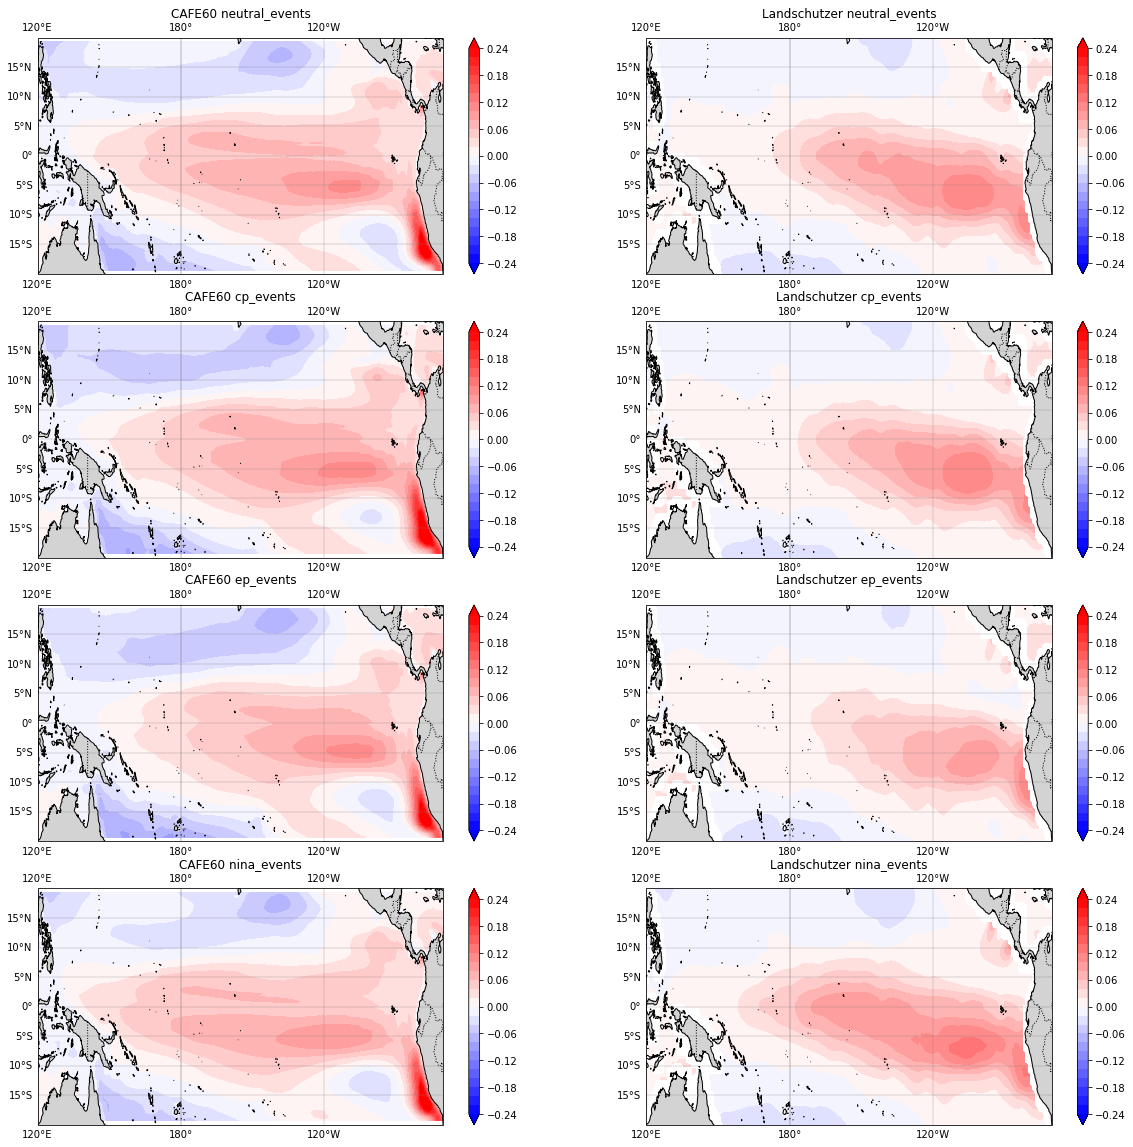

In [22]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Landschutzer']):
    
        ax = plt.subplot(4,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=(eqpac.stf10/1000)*86400*-12
        elif i==1:
            dat=land_co2.fgco2_smoothed
        data=dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.24,0.26,0.02),extend='both')
        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' '+event_name)
        plot_counter+=1
plt.show()

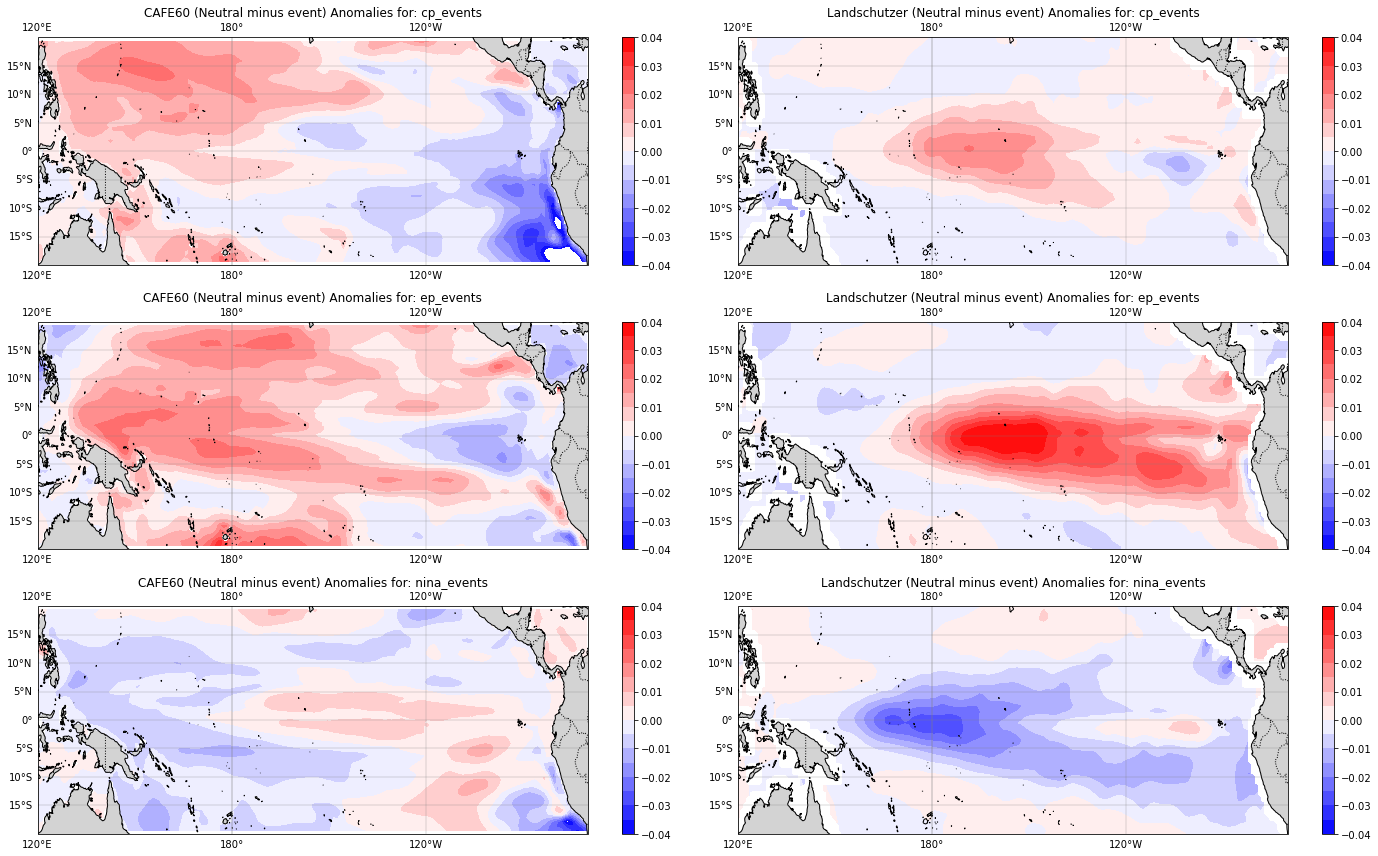

In [23]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Landschutzer']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=(eqpac.stf10/1000)*86400*-12
        elif i==1:
            dat=land_co2.fgco2_smoothed
        data=dat.sel(time=neutral_events,method='nearest').mean(dim='time')-dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.04,0.045,0.005))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' (Neutral minus event) Anomalies for: '+event_name)
        plot_counter+=1
plt.tight_layout()
plt.show()

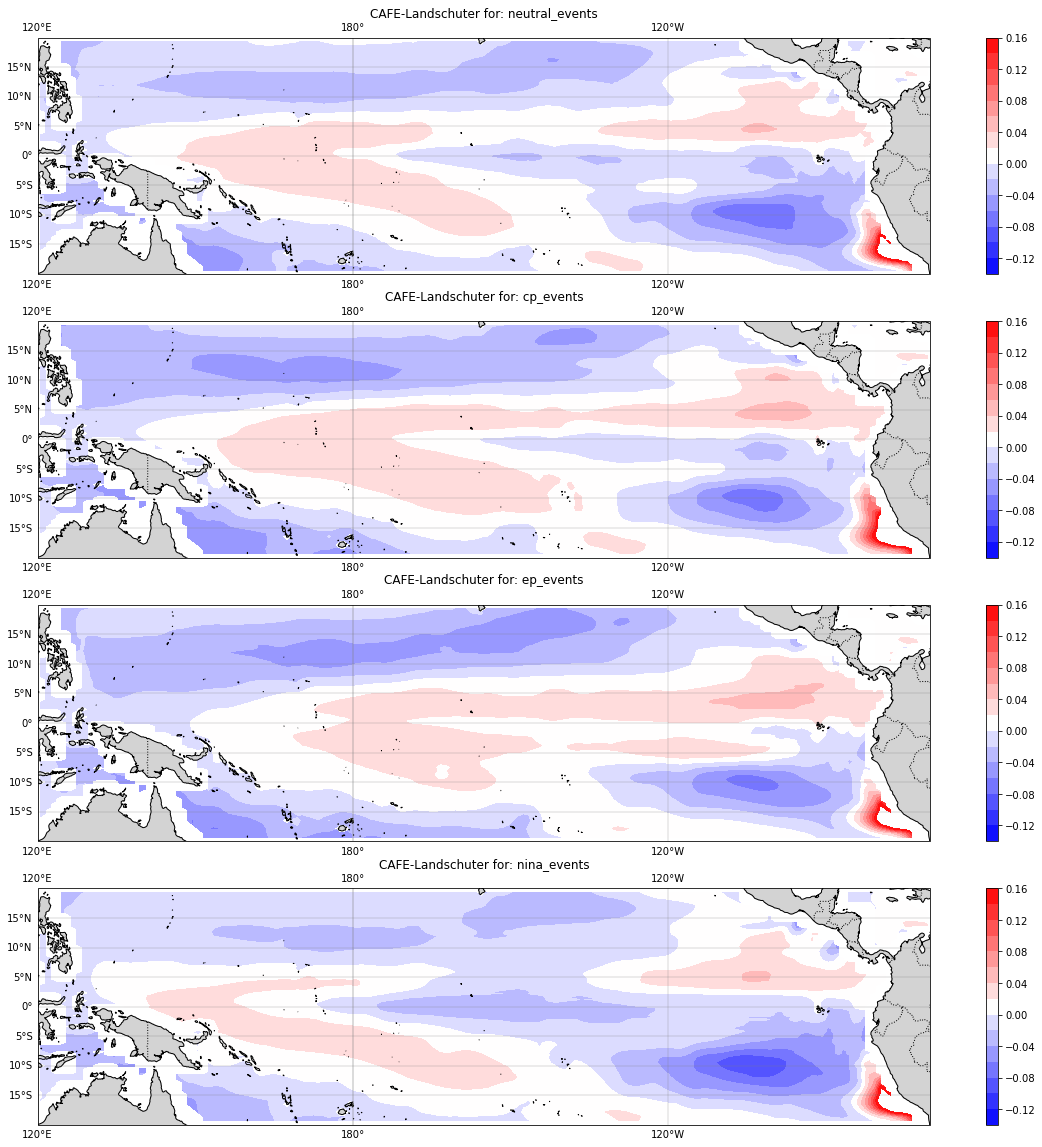

In [24]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):

        ax = plt.subplot(4,1,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
     
        cafe=(eqpac.stf10/1000)*86400*-12
        land=land_co2.fgco2_smoothed
        
        data=cafe.sel(time=times,method='nearest').mean(dim='time')-land.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-0.14,0.16,0.02))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title('CAFE-Landschuter for: '+event_name)
        plot_counter+=1
plt.show()

In [16]:
best_ens=25

phys=xr.open_zarr('/g/data/xv83/dcfp/CAFE60v1/ocean_month.zarr.zip')
phys=phys.rename({'xt_ocean':'lon','yt_ocean':'lat'})
phys['lon']=phys['lon']+360
eqpac_phys=phys.sel(lon=slice(120,290),lat=slice(-20,20),ensemble=best_ens)
eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')
#eqpac.time
eqpac_phys.sst

/local/v45/np1383/tmp/ipykernel_2722792/1844139029.py:7: RuntimeWarning: Converting a CFTimeIndex with dates from a non-standard calendar, 'julian', to a pandas.DatetimeIndex, which uses dates from the standard calendar.  This may lead to subtle errors in operations that depend on the length of time between dates.
  eqpac_phys['time']=np.array(eqpac_phys.indexes['time'].to_datetimeindex(), dtype='datetime64[M]')


<xarray.DataArray 'sst' (time: 720, lat: 98, lon: 170)>
dask.array<getitem, shape=(720, 98, 170), dtype=float32, chunksize=(1, 98, 170), chunktype=numpy.ndarray>
Coordinates:
    ensemble  int32 25
  * time      (time) datetime64[ns] 1960-01-01 1960-02-01 ... 2019-12-01
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * lat       (lat) float64 -19.36 -18.59 -17.85 -17.15 ... 17.85 18.59 19.36
Attributes:
    cell_methods:   time: mean
    long_name:      Potential temperature
    standard_name:  sea_surface_temperature
    units:          degrees C
    valid_range:    [-10.0, 500.0]

In [17]:
rey_sst.sst

<xarray.DataArray 'sst' (time: 456, lat: 300, lon: 360)>
[49248000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-01-01 1982-02-01 ... 2019-12-01
  * lon      (lon) float64 80.5 81.5 82.5 83.5 84.5 ... 436.5 437.5 438.5 439.5
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77

In [18]:
# DO SST NOW

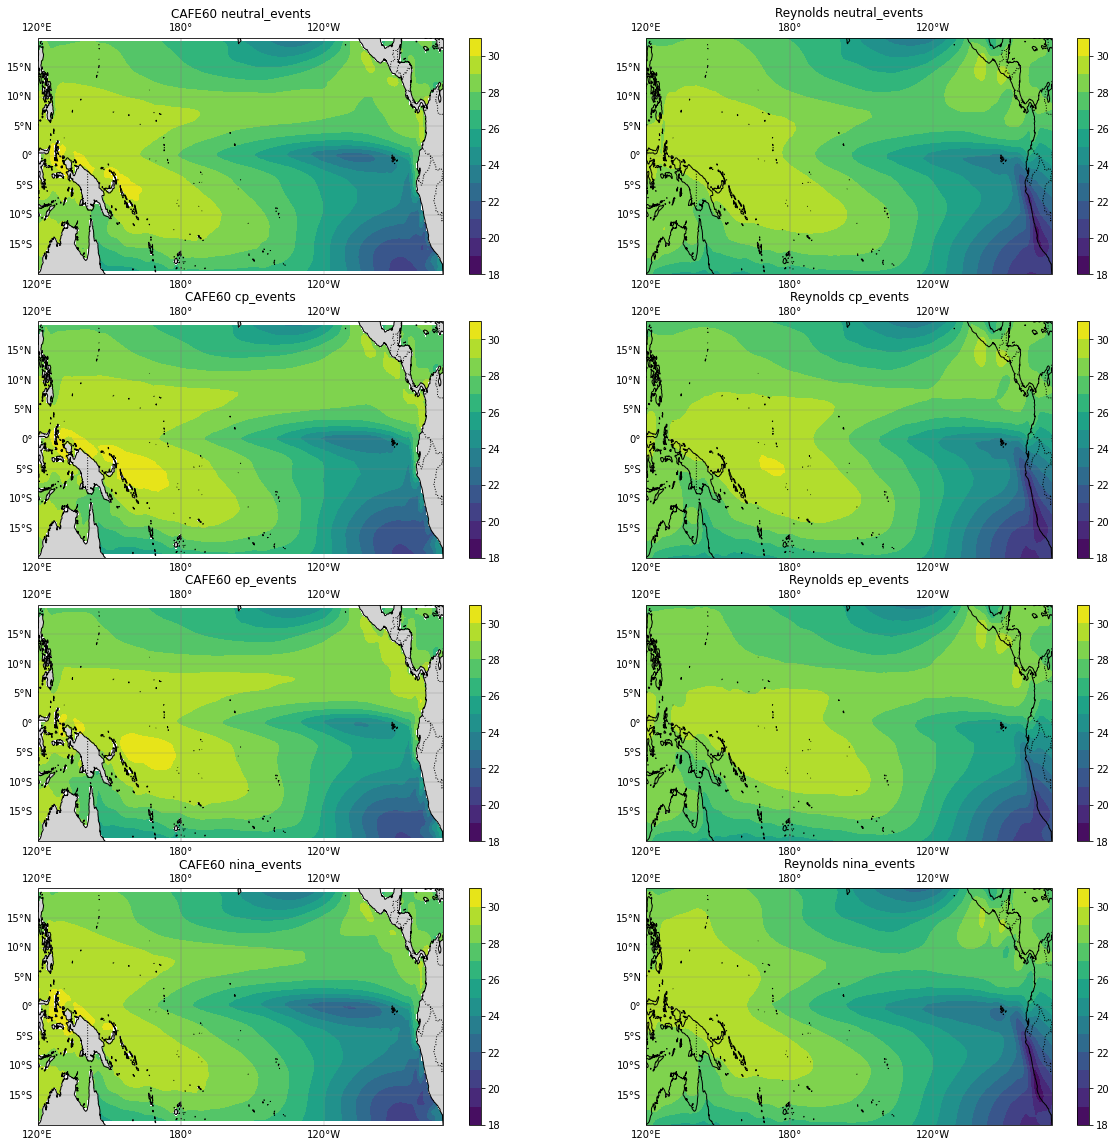

In [19]:
# SHOW DIFFERENCES BETWEEN CAFE AND Reynolds SST AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(4,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='viridis',levels=np.arange(18,32,1))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' '+event_name)
        plot_counter+=1
plt.show()

In [47]:
d

<xarray.DataArray 'sst' (time: 62, lat: 300, lon: 360)>
[6696000 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 1982-03-01 1982-04-01 ... 2019-12-01
  * lon      (lon) float64 80.5 81.5 82.5 83.5 84.5 ... 436.5 437.5 438.5 439.5
  * lat      (lat) float64 -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77

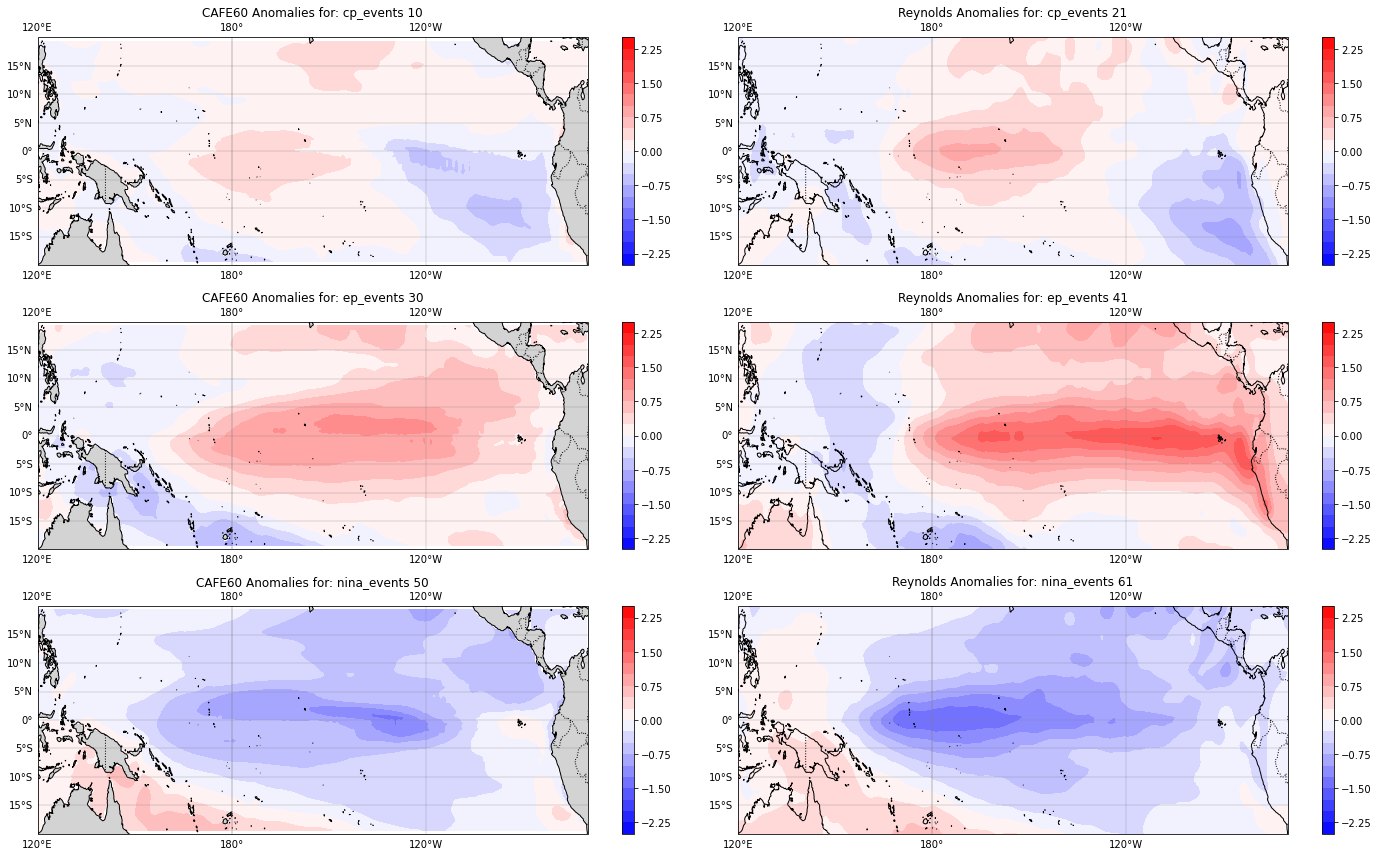

In [67]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,12))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event_name in ['cp_events','ep_events','nina_events']:
    for i,product in enumerate(['CAFE60','Reynolds']):
    
        ax = plt.subplot(3,2,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
        if i==0:
            dat=eqpac_phys.sst
        elif i==1:
            dat=rey_sst.sst
        data=dat.sel(time=times,method='nearest').mean(dim='time')-dat.sel(time=neutral_events,method='nearest').mean(dim='time')
                 
        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-2.5,2.75,0.25))

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title(product+' Anomalies for: '+event_name+' '+str(plot_counter)+str(i))
        plot_counter+=1
plt.tight_layout()
plt.show()

In [39]:
neutral_events

array(['1982-01-01T00:00:00.000000000', '1982-02-01T00:00:00.000000000',
       '1983-08-01T00:00:00.000000000', '1983-09-01T00:00:00.000000000',
       '1983-10-01T00:00:00.000000000', '1983-11-01T00:00:00.000000000',
       '1983-12-01T00:00:00.000000000', '1984-01-01T00:00:00.000000000',
       '1984-02-01T00:00:00.000000000', '1984-03-01T00:00:00.000000000',
       '1984-04-01T00:00:00.000000000', '1984-05-01T00:00:00.000000000',
       '1984-06-01T00:00:00.000000000', '1984-07-01T00:00:00.000000000',
       '1984-08-01T00:00:00.000000000', '1984-09-01T00:00:00.000000000',
       '1984-10-01T00:00:00.000000000', '1984-11-01T00:00:00.000000000',
       '1984-12-01T00:00:00.000000000', '1985-01-01T00:00:00.000000000',
       '1985-02-01T00:00:00.000000000', '1985-03-01T00:00:00.000000000',
       '1985-04-01T00:00:00.000000000', '1985-05-01T00:00:00.000000000',
       '1985-06-01T00:00:00.000000000', '1985-07-01T00:00:00.000000000',
       '1985-08-01T00:00:00.000000000', '1985-09-01

In [38]:
#neutral_eebtsm
#cp events, ep events, nina events
ep_events

array(['1982-06-01T00:00:00.000000000', '1982-07-01T00:00:00.000000000',
       '1982-08-01T00:00:00.000000000', '1982-09-01T00:00:00.000000000',
       '1982-10-01T00:00:00.000000000', '1982-11-01T00:00:00.000000000',
       '1982-12-01T00:00:00.000000000', '1983-01-01T00:00:00.000000000',
       '1983-02-01T00:00:00.000000000', '1983-03-01T00:00:00.000000000',
       '1983-04-01T00:00:00.000000000', '1983-05-01T00:00:00.000000000',
       '1983-06-01T00:00:00.000000000', '1983-07-01T00:00:00.000000000',
       '1986-09-01T00:00:00.000000000', '1986-10-01T00:00:00.000000000',
       '1986-11-01T00:00:00.000000000', '1986-12-01T00:00:00.000000000',
       '1987-01-01T00:00:00.000000000', '1987-02-01T00:00:00.000000000',
       '1987-03-01T00:00:00.000000000', '1987-04-01T00:00:00.000000000',
       '1987-05-01T00:00:00.000000000', '1987-06-01T00:00:00.000000000',
       '1987-07-01T00:00:00.000000000', '1987-08-01T00:00:00.000000000',
       '1987-09-01T00:00:00.000000000', '1987-10-01

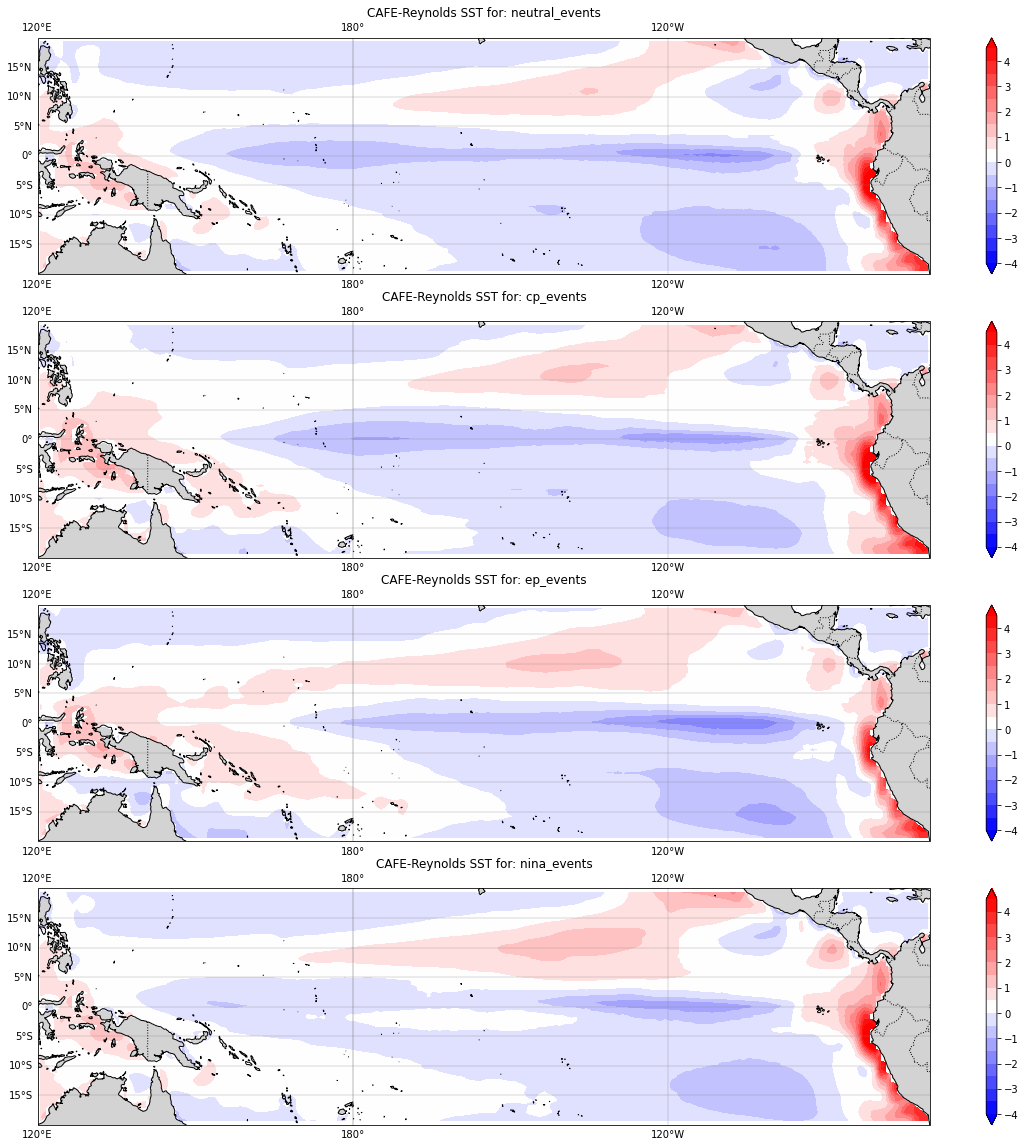

In [21]:
# SHOW DIFFERENCES BETWEEN CAFE AND LAND CO2 FLUX AT ENSO PHASE.
fig = plt.figure(figsize=(20,20))
# this declares a recentered projection for Pacific areas
usemap_proj = ccrs.PlateCarree(central_longitude=180)
usemap_proj._threshold /= 20.  # to make greatcircle smooth


plot_counter=1

for event,event_name in enumerate(['neutral_events','cp_events','ep_events','nina_events']):

        ax = plt.subplot(4,1,plot_counter,projection=usemap_proj)
        ax.set_extent([120, 290, -20, 20], crs=ccrs.PlateCarree()) # set appropriate extents: (lon_min, lon_max, lat_min, lat_max)

        geodetic = ccrs.Geodetic()
        plate_carree = ccrs.PlateCarree(central_longitude=180)

        times=eval(event_name)
     
        cafe=eqpac_phys.sst
        reynolds=rey_sst.sst

        data=cafe.sel(time=times,method='nearest').mean(dim='time')-reynolds.sel(time=times,method='nearest').mean(dim='time')

        plot=ax.contourf(data.lon,data.lat,data,transform=ccrs.PlateCarree(),cmap='bwr',levels=np.arange(-4,5,0.5),extend='both')

        ax.add_feature(cfeature.LAND, color='lightgray')
        ax.add_feature(cfeature.COASTLINE)
        ax.add_feature(cfeature.BORDERS, linestyle=':')
        ax.gridlines(draw_labels=True, crs=ccrs.PlateCarree(), color='gray', linewidth=0.3)
        plt.colorbar(plot,ax=ax)
        ax.set_aspect('auto', adjustable=None)
        plt.title('CAFE-Reynolds SST for: '+event_name)
        plot_counter+=1
plt.show()